# More on feature engineering

In this notebook, we return to the topic of feature engineering from the previous lecture, but look at more complex examples. 

Many of these examples combine **domain knowledge** with machine learning. What this means is that the kind of data we have lends itself to certain types of features engineering that may not apply to other types of data. The best way to learn about this kind of feature engineering is by looking at examples: 

- feature engineering with text data
- with time series data
- with image or video data
- with sound data
- and so on.

So as our example, we will look at feature engineering for text data. To make things more interesting, we finish this notebook by training a supervised learning algorithm on the resulting data. This last part will warm us up for next week's lecture!

Let's look at an example dealing with text data. Raw text data is an unstructured and ubiquitous type of data. Most of the world’s data is unstructured. Volumes of unstructured data, including text, are growing much faster than structured data. There are many industry estimates for the fraction of all data which is unstructured. How much text data are we talking about here? In a few years time, Twitter will have [more text data recorded](http://www.internetlivestats.com/twitter-statistics/) than all that has been written in print in the history of mankind.

Given the ubiquity and volume of text data, it is not surprising that numerous powerful applications which exploit text analytics are appearing. A few of these applications are listed below.

- Intelligent applications
  - Assistants
  - Chat bots
- Classification
  - Sentiment analysis
  - SPAM detection
- Speech recognition
- Search
- Information retrieval
- Legal discovery

In this tutorial we investigate two areas of text analytics:

- Pre-processing text data for analysis
- Classification of text and sentiment analysis

In [1]:
import string
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cProfile
import seaborn as sns

from scipy.sparse import coo_matrix # this is the sparse matrix format discussed in lecture

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

### Natural Language Processing (NLP) in Python
- The main NLP package in Python is nltk
- You may need to download some accessory packages like 'wordnet' or 'stopwords'

Uncomment the following four nltk.download statements if you need to.

In [ ]:
import nltk

# # A one-time requirement for these four downloads:
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('corpus')

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package wordnet to /Users/white/nltk_data...
[nltk_data] Downloading package stopwords to /Users/white/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /Users/white/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Error loading corpus: Package 'corpus' not found in index


The very first step to prepare text is to clean it.  We clean and normalize the text by performing various operations on the text. Some examples are as follows:

- Make the text lowercase.
- Remove symbols or punctuation.
- Remove numbers. May also replace all numbers with a numeric tag, for example `<NUM>` or similar. We may also consider replacing all dates with `<DATE>` or similarly use tags `<URL>`, `<PHONE>`, `<EMAIL>`, etc...
- Strip extra white space. White space has many forms: space, newline, or tab. There are also other rarely used unicode specifications for other white space characters.
- Remove all non-printable unicode characters.
- Replace accent characters.
- Remove 'stop words'. Stop words are generally non-informative words like "the", "as", "a", etc.
- Stem words to similar endings, such as "eats" and "eat".

There are a few reasons to clean your text.  The primary reason is to reduce the potential vocabulary and increase the observations of specific words (or tokens). Depending on the application, the above steps should be considered carefully and only applied when it makes sense. Ask yourself if words like "China" and "china" should be different.

**NOTE**: Be careful dealing with unicode characters. There are many editors and text viewers that only display printable characters but will not remove non-printable characters. Strange unicode characters can end up in data from users blindly copy/pasting text (with invisible unicode) into other text boxes.

### Exercise (8 minutes)

By its very nature, text data comes unstructured and poorly organized for analysis. Typically multiple steps are required to process text into a form suitable for analysis, starting with cleaning it.

Here's a horrible tweet. We're going to clean it and learn about ways to clean text data in the process.

In [3]:
horrible_tweet_text = 'I <3 cleaning data $\ \ $, it’s my \u1072  $\ \ $    fAvoRitEs!! 11!!!'
print('Unfiltered text: \n{}\n'.format(horrible_tweet_text))

Unfiltered text: 
I <3 cleaning data $\ \ $, it’s my ၲ  $\ \ $    fAvoRitEs!! 11!!!



<>:1: SyntaxWarning: invalid escape sequence '\ '
<>:1: SyntaxWarning: invalid escape sequence '\ '
/var/folders/_l/9c97q4ms35gg7r1hrlmv00cr0000ng/T/ipykernel_86110/572679933.py:1: SyntaxWarning: invalid escape sequence '\ '
  horrible_tweet_text = 'I <3 cleaning data $\ \ $, it’s my \u1072  $\ \ $    fAvoRitEs!! 11!!!'


Step by step, refine the above text. To avoid overwriting the existing string, you can create a new string from the string so far each time.

#### Non-ASCII Characters
- A string `x` is ASCII if `ord(x) < 128`.  

For instance:  

In [63]:
print("\u0050 is #{}; \u1072 is #{}; \u79d1 is #{}".format(ord('\u0050'), ord('\u1072'), ord('\u79d1')))

P is #80; ၲ is #4210; 科 is #31185


#### Remove any non-ASCI character. 

In [73]:
# Add code here to remove non-ASCII characters 001
AsciiString = str().join([c for c in horrible_tweet_text if ord(c) < 128])

AsciiString

'I <3 cleaning data $\\ \\ $, its my   $\\ \\ $    fAvoRitEs!! 11!!!'

#### Make Lowercase
- Make all the letters lower case.

In [74]:
AsciiString = AsciiString.lower()
print("String in lowercase:\n", AsciiString) 

String in lowercase:
 i <3 cleaning data $\ \ $, its my   $\ \ $    favorites!! 11!!!


#### Remove Punctuation
- Remove all punctuation from the text. You can use `string.punctuation` to get a string of all punctuation characters.

In [75]:
# Add code here 002
AsciiString = str().join(c for c in AsciiString if c not in string.punctuation)
AsciiString

'i 3 cleaning data    its my         favorites 11'

#### Remove Numbers
- Remove all the numbers from the text. HINT: If you are familiar with **regular expressions** you can use `re.sub` to do this easily.

In [76]:
# Add code here 003
AsciiString = re.sub(r"\d", "", AsciiString)
AsciiString

'i  cleaning data    its my         favorites '

#### Trim Whitespace
- Strip the text of any extra whitespace. HINT: The `split` method might help here.  Using `split` creates a list of words.

In [77]:
# Add code here 004
AsciiString =  " ".join([c for c in AsciiString.split()])
AsciiString

'i cleaning data its my favorites'

#### Remove Stopwords
- Remove all stop words from the text. We can use `stopwords.words('english')` to get a list of stop words for the English language.

In [78]:
# Add code here 005
AsciiString = " ".join([w for w in AsciiString.split() if w not in stopwords.words('english')])
AsciiString

'cleaning data favorites'

#### Lemmatize vs. Stemming
- Here is an example of how words can be changed by lemmatization:
    - rocks : rock
    - corpora : corpus
    - better : good
- Here is an example of how words are changed by traditional stemming
    - rocks : rock
    - corpora : corp
    - better : better
- Let's now use `WordNetLemmatizer()` to reduce the words to their **stems**. HINT: Use the object's `lemmatize` method.  

In [79]:
# Add code here 006
lemmet = WordNetLemmatizer()

AsciiString = " ".join([lemmet.lemmatize(w) for w in AsciiString.split()])
AsciiString

'cleaning data favorite'

### End of exercise

Let's now combine the steps outlined in the above exercise and create a function to clean text for use. We will later use this function.

In [80]:
def preprocess(text, list_of_steps):
    
    for step in list_of_steps:
        if step == 'remove_non_ascii':
            text = ''.join([x for x in text if ord(x) < 128])
        elif step == 'lowercase':
            text = text.lower()
        elif step == 'remove_punctuation':
            punct_exclude = set(string.punctuation)
            text = ''.join(char for char in text if char not in punct_exclude)
        elif step == 'remove_numbers':
            text = re.sub("\d+", "", text)
        elif step == 'strip_whitespace':
            text = ' '.join(text.split())
        elif step == 'remove_stopwords':
            stops = stopwords.words('english')
            word_list = text.split(' ')
            text_words = [word for word in word_list if word not in stops]
            text = ' '.join(text_words)
        elif step == 'stem_words':
            lmtzr = WordNetLemmatizer()
            word_list = text.split(' ')
            stemmed_words = [lmtzr.lemmatize(word) for word in word_list]
            text = ' '.join(stemmed_words)
    return text

step_list = ['remove_non_ascii', 'lowercase', 'remove_punctuation', 'remove_numbers',
            'strip_whitespace', 'remove_stopwords', 'stem_words']

print("before: \"{}\"".format(horrible_tweet_text))
print("after : \"{}\"".format(preprocess(horrible_tweet_text, step_list)))

before: "I <3 cleaning data $\ \ $, it’s my ၲ  $\ \ $    fAvoRitEs!! 11!!!"
after : "cleaning data favorite"


<>:12: SyntaxWarning: invalid escape sequence '\d'
<>:12: SyntaxWarning: invalid escape sequence '\d'
/var/folders/_l/9c97q4ms35gg7r1hrlmv00cr0000ng/T/ipykernel_86110/594333260.py:12: SyntaxWarning: invalid escape sequence '\d'
  text = re.sub("\d+", "", text)


#### Order Matters
- Why do the following preprocess commands have different effects?  
- Can you think of any other examples where the order of preprocessing text matters?

In [81]:
my_string = 'we took statistics200'

print('first stem then remove numbers:"', preprocess(my_string, ['stem_words', 'remove_numbers']), '"')
print('first remove numbers then stem:"', preprocess(my_string, ['remove_numbers', 'stem_words']), '"')

first stem then remove numbers:" we took statistics "
first remove numbers then stem:" we took statistic "


### Featurizing text data

With clean data we can begin to ask what is the best way to extract features from the data. There are many more approaches for text analytics and natural language processing (NLP). We only mention a few below. Note that the collection of unique words in the data is called a **vocabulary**. To avoid having a vocabulary that's too large, we can trim it by keeping the most frequent $N$ words, making $N$ the size of the vocabulary. A **document** usually refers to a single data point with raw text, such as a tweet, a review, an invoice, etc. So our documents are made up of "words" that come from the corpus (ignoring any words that are not in the vocabulary). The question now is how do we represent such a data numerically? Here are two approaches:

- The **bag of words model (BoW)** is a simple and surprisingly effective model for analysis of text data. The BoW model creates a **sparse vector representation** of each word in the corpus based on the frequency of the words in the document. The order of the words is not considered, nor is the similarity between different words. Despite serious shortcomings, the model can work well in many cases.
- We can usually do much better by using **word embeddings**, which are **dense vector respresentations** for each word in the corpus. Word embeddings are learned by examining the word's **context** (other words around it). Word embeddings are very common in **deep learning** applications of NLP, although the embeddings themselves are learned using a shallow network. If we learn word embeddings from a very large data set once, we can save and re-use these word embeddings to create features for other data sets. In fact, **pre-trained word embeddings** are trained by large companies like Google and made available for use by others. So we can load these embeddings and numerically represent a document using the average of the embeddings of the words in it. Because word embeddings are vectors, such an average would also be a vector that is a dense representation of the document.

As you can see, BoW models seem too simplistic and word embeddings seem a bit too sophisticated (I mean in the context of DATASCI 510 course). So here's another approach that is sort of between the two in terms of difficulty. It is called **TF-IDF** and it is a clever way to featurize words in documents. Just like a BoW model, we begin by "tokenizing" the data. In BoW we then create a one-hot encoded feature for each token (or word). But in TF-IDF we first extract the relative word frequencies per document (called **term frequencies** or TF), we then multiply the term frequencies by a multiplier we call IDF. This has the effect of dampening the values for terms that appear frequently across documents, giving them less influence when we move on to the machine learning phase. Note that we used the words "token", "word" and "term" almost interchangeably. Sorry for confusing you! Data scientists don't always agree on terminology.

### Tokenize text

As a first step in preparing text for analysis of a document is to **tokenize** the text. In general terms, tokenization is the process dividing raw text into words, symbols and other elements, known as **tokens**. A set of tokens from all documents in the data is known as a **corpus**.

As a first step in creating a corpus is reading the data set. This particular data set is comprised of 160,000 tweets. The sentiment of these tweets has been human labeled as positive or negative (4 is for positive).

In [82]:
data_file = '../../data/twitter_data.csv'
tweet_df = pd.read_csv(data_file)[0:50000]
print(tweet_df.shape)
tweet_df.head()

(50000, 2)


,sentiment_label,tweet_text
0,4,"@elephantbird Hey dear, Happy Friday to You A..."
1,4,Ughhh layin downnnn Waiting for zeina to co...
2,0,"@greeniebach I reckon he'll play, even if he's..."
3,0,@vaLewee I know! Saw it on the news!
4,0,very sad that http://www.fabchannel.com/ has c...


Now that we have the data set read, we need to clean and then tokenize the tweets. Note that stemming can be slow on large datasets. It's sometimes helpful to profile such functions to find the main culprits and see if we can do anything to speed them up.

In [115]:
steps = ['remove_non_ascii','lowercase', 'remove_punctuation', 'remove_numbers', 'strip_whitespace', 'stem_words']
#tweet_df['clean_tweet'] = tweet_df['tweet_text'].map(lambda s: preprocess(s, steps))
cProfile.run("tweet_df['clean_tweet'] = tweet_df['tweet_text'].map(lambda s: preprocess(s, steps))");

         19871662 function calls (19871640 primitive calls) in 4.624 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    50000    0.496    0.000    4.601    0.000 594333260.py:1(preprocess)
  3527539    0.209    0.000    0.209    0.000 594333260.py:10(<genexpr>)
        2    0.000    0.000    0.000    0.000 <frozen abc>:121(__subclasscheck__)
   648493    0.177    0.000    0.284    0.000 <frozen importlib._bootstrap>:1390(_handle_fromlist)
    50000    0.029    0.000    4.631    0.000 <string>:1(<lambda>)
        1    0.000    0.000    4.623    4.623 <string>:1(<module>)
    50000    0.018    0.000    0.113    0.000 __init__.py:179(sub)
    50000    0.016    0.000    0.024    0.000 __init__.py:280(_compile)
        6    0.000    0.000    0.000    0.000 __init__.py:34(using_copy_on_write)
        2    0.000    0.000    0.000    0.000 __init__.py:42(warn_copy_on_write)
        1    0.000    0.000    0.000    0.000 __init__.py

In [116]:
tweet_df.head(10)

,sentiment_label,tweet_text,clean_tweet
0,1,"@elephantbird Hey dear, Happy Friday to You A...",elephantbird hey dear happy friday to you alre...
1,1,Ughhh layin downnnn Waiting for zeina to co...,ughhh layin downnnn waiting for zeina to cook ...
2,0,"@greeniebach I reckon he'll play, even if he's...",greeniebach i reckon hell play even if he not ...
3,0,@vaLewee I know! Saw it on the news!,valewee i know saw it on the news
4,0,very sad that http://www.fabchannel.com/ has c...,very sad that httpwwwfabchannelcom ha closed d...
5,0,@Fearnecotton who sings 'I Remember'? i always...,fearnecotton who sings i remember i alwaysss h...
6,1,With God on ur side anything is possible....,with god on ur side anything is possible
7,0,@LoveSmrs why being stupid?,lovesmrs why being stupid
8,0,Having delved back into the guts of Expression...,having delved back into the gut of expression ...
9,0,@emoskank awww take him with you!,emoskank awww take him with you


**NOTE:** To help us understand TF-IDF in great detail, we learn about TF-IDF in two different ways:

- We first run through the steps "manually", so that we can see more of the implementation details. 
- We then apply TF-IDF using `sklearn` in a few lines of code, which will hide all of that detail.

## Computing TF-IDF

Computing the TF-IDF values manually consist of several steps:
1. We obtain the term-document matirx. 
1. We calculate the **term-frequency (TF)** matirx, where $\text{TF(doc, term)}$ is the term frequencies from the term document matrix divided by the total number of terms in the document. In other words, we turn the frequencies into percentages (also called relative frequencies).
1. We trim the term-document matrix if needed. This gets rid of useless words that frequently appear across documents.
1. We can also derive the **inverse document frequencies (IDF)** matrix:

   $$\text{IDF(term)} = \log(\frac{\text{number of documents + 1}}{\text{number of documents with term in it} + 1})$$

   Note that TF is a function of both term and document, but the IDF is just a function of the terms.
1. We multiply the TF with IDF values to get TF-IDF values. This results in **term frequency inverse document frequency (TF-IDF) maxtrix**. 
   
   $$\text{TF-IDF} = \text{TF(term, doc)} \cdot \text{IDF(term)}$$

To get an intuition behind what's happening, here's what the IDF function looks like:

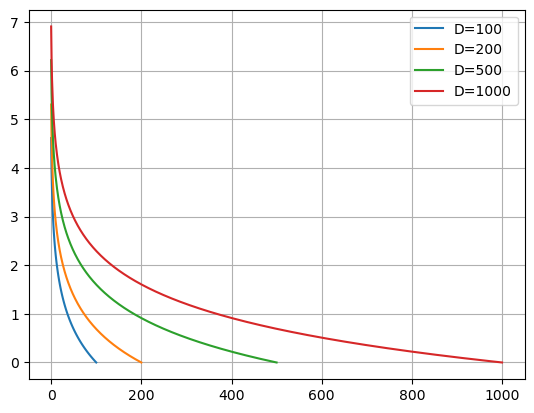

In [117]:
%matplotlib inline
DD = [100, 200, 500, 1000] # number of documents
for D in DD:
    x = np.linspace(0, D, num=D+1) # number of documents with the term
    sns.lineplot(x = x, y = np.log((D + 1) / (x + 1)), label=f"D={D}")
plt.legend()
plt.grid();

TFs give us the relative frequency terms in the documents. We use the IDFs to then dampen the TFs for terms that appear frequently across documents by virtue of being common terms. This will make it so rarer terms get to exert more influence during the machine learning phase.

Applications of TF-IDF include

- Characterize writing styles
- Comparing authors
- Determining original authors
- Finding plagiarism

Let's now implement this for the tweet data:

### Step 1: Get the term-document matrix

<img src="https://www.ferventlearning.com/wp-content/uploads/2020/12/articleImagery_IAWNLP-ABF-28_4-1536x864.jpg" alt="drawing" width="480"/>

We first break up the words in the text:

In [118]:
clean_texts = tweet_df['clean_tweet']
docs = {}
for ix, row in enumerate(clean_texts):
    docs[ix] = row.split(' ')

In [119]:
print('Example entry: {}\n\nFrom the {} possible documents.'.format(docs[np.random.choice(ix)], tweet_df.shape[0]))

Example entry: ['im', 'so', 'excited', 'for', 'glee', 'on', 'tuesday']

From the 50000 possible documents.


In [120]:
numberOfWords = 0
for word_list in docs.values():
    numberOfWords += len(word_list)
print('Our cleaned tweet corpus has', numberOfWords, 'words')

Our cleaned tweet corpus has 648488 words


We can now create our document-term matrix, keeping track of its size.

In [121]:
num_nonzero = 0
vocab = set()

for word_list in docs.values():
    unique_terms = set(word_list)    # all unique terms of this tweet
    vocab.update(unique_terms)       # set union: add unique terms of this tweet
    num_nonzero += len(unique_terms) # add count of unique terms in this tweet for the COO sparse matrix

print('Our tweet-vocabulary has {:,} distinct words.'.format(len(vocab)))
print('That is out of a total number of {:,} unique words in each document, in the corpus.'.format(num_nonzero))

Our tweet-vocabulary has 60,780 distinct words.
That is out of a total number of 612,791 unique words in each document, in the corpus.


Let's now convert everything to a numpy array. We should keep track of how the vocab/term indices map to the matrix so that we can look them up later.

In [122]:
vocab = np.array(list(vocab))
print('Some example vocabulary: {}'.format(vocab[:20]))

Some example vocabulary: ['maryssfromparis' 'ladysuperastro' 'ike' 'whymakes' 'deafening' 'fishin'
 'sherridan' 'areadidnt' 'change' 'kemorri' 'turned' 'roomate' 'msnarain'
 'princessjenn' 'justwowthough' 'fearless' 'galleria' 'everyting' 'sti'
 'wkndran']


We now initialize the **document-term matrix**. This is a matrix where each row $i$ is a document and each column $j$ is a word. The entry $(i, j)$ of the matrix shows the frequency of the word $j$ in document $i$.

In [123]:
# Let's allow indexing on the vocabulary 
vocab_sorter = np.argsort(vocab)

# doc_key_list = np.array(list(docs.keys()))
vocab_size = len(vocab)

data = np.empty(num_nonzero, dtype = np.intc)     # all non-zero
rows = np.empty(num_nonzero, dtype = np.intc)     # row index
cols = np.empty(num_nonzero, dtype = np.intc)     # column index

We can now populate the document-term matrix (DTM). Each row $i$ is a document and each column $j$ is a word. The entry $(i, j)$ of the matrix shows the frequency of the word $j$ in document $i$.  <br/><br/> In our code:
- rows contain the document number
- cols contains the word index
- data contains the number of times a given word appeared in a given document

In [124]:
ix = 0
# go through all documents with their terms

print('Computing, please wait!')

for doc_key, terms in docs.items():
    # find indices to insert-into such that, if the corresponding elements were
    # inserted before the indices, the order would be preserved
    term_indices = vocab_sorter[np.searchsorted(vocab, terms, sorter = vocab_sorter)]
    
    # count the unique terms of the document and get their vocabulary indices
    uniq_indices, counts = np.unique(term_indices, return_counts = True)
    n_vals = len(uniq_indices)  # number of unique terms
    ix_end = ix + n_vals # add count to index
    data[ix:ix_end] = counts                  # save the counts (term frequencies)
    cols[ix:ix_end] = uniq_indices            # save the column index: index in 
    
    # doc_ix = np.where(doc_key_list == doc_key)   # get the document index for the document name
    # rows[ix:ix_end] = np.repeat(doc_ix, n_vals)  # save it as repeated value
    rows[ix:ix_end] = np.repeat(doc_key, n_vals)  # save it as repeated value
    ix = ix_end  # resume with next document -> will add future data on the end

print('Done!')

Computing, please wait!
Done!


In [125]:
print('rows refers to documents {} through {:,}'.format(min(rows), max(rows)))
print('cols refers to token indices {} through {:,}'.format(min(cols), max(cols)))
print('data indicates that a term may occur from {} to {} times in a document'.format(min(data), max(data)))

rows refers to documents 0 through 49,999
cols refers to token indices 0 through 60,779
data indicates that a term may occur from 1 to 19 times in a document


Let's look at our sorted vocabulary to see examples of words that we may not need.

In [126]:
print('Sorted Vocab: {}'.format(vocab[vocab_sorter[:50]]))

Sorted Vocab: ['a' 'aa' 'aaa' 'aaaaaa' 'aaaaaaaaaaaaaaaa'
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaa' 'aaaaaaaaaaaaaaah'
 'aaaaaaaaaaaaaaahmmmmmmmmmm' 'aaaaaaaaaaaaaah'
 'aaaaaaaaaaaaaahhhhhhhhhhhhhhhhhhhhhhhhhhhhhh' 'aaaaaaaaand' 'aaaaaaaall'
 'aaaaaaaaw' 'aaaaaaah' 'aaaaaah' 'aaaaaaw' 'aaaaache' 'aaaaah' 'aaaaare'
 'aaaaarg' 'aaaaarghgmorning' 'aaaaarrrrgggghhhh' 'aaaaaw' 'aaaah'
 'aaaahh' 'aaaahhh' 'aaaahhhh' 'aaaamm' 'aaaand' 'aaaaw' 'aaaawesome'
 'aaaawh' 'aaackkk' 'aaagh' 'aaah' 'aaahh' 'aaahhaa' 'aaahhh' 'aaahhhh'
 'aaahhhhh' 'aaahhhhhh' 'aaahhhwwww' 'aaakritilove' 'aaalisson'
 'aaallrighhtt' 'aaam' 'aaamaazing' 'aaammaaazzziinngg' 'aaamyzing'
 'aaand']


As you can see, we probably need to do some trimming, as the word 'aaaaa' probably doesn't occur often enough, and having 60K+ unique words may be too much.  We will address this later on. For now, let's keep the corpus we have. We now construct a COO sparse matrix for the document-term matrix encoded by `rows`, `cols`, and `data`.

In [127]:
doc_term_mat = coo_matrix((data, (rows, cols)), shape = (tweet_df.shape[0], vocab_size), dtype = np.intc)
doc_term_mat

<COOrdinate sparse matrix of dtype 'int32'
	with 612791 stored elements and shape (50000, 60780)>

In [128]:
# We can use the binary sentiment label.
# The sentiment label has values 4 and 0.
# Typically, binary labels have values 1 and 0.
# Replace label "4" with label "1":
tweet_df['sentiment_label'] = tweet_df['sentiment_label'].replace(4, 1)

# Convert a copy of the tweets as list for use later
tweet_data = tweet_df.values.tolist()
print(tweet_df['sentiment_label'].value_counts())
tweet_df.head()

sentiment_label
0    25121
1    24879
Name: count, dtype: int64


,sentiment_label,tweet_text,clean_tweet
0,1,"@elephantbird Hey dear, Happy Friday to You A...",elephantbird hey dear happy friday to you alre...
1,1,Ughhh layin downnnn Waiting for zeina to co...,ughhh layin downnnn waiting for zeina to cook ...
2,0,"@greeniebach I reckon he'll play, even if he's...",greeniebach i reckon hell play even if he not ...
3,0,@vaLewee I know! Saw it on the news!,valewee i know saw it on the news
4,0,very sad that http://www.fabchannel.com/ has c...,very sad that httpwwwfabchannelcom ha closed d...


We populated the matrix with the term frequencies. We can see an example of this for the word "python" in the code below.

In [129]:
# let's check to make sure!
vocab_list = list(vocab)
word_of_interest = 'python'
vocab_interesting_ix = list(vocab).index(word_of_interest)
print('vocab index of {} : {}'.format(word_of_interest, vocab_interesting_ix))
# find which tweets contain word
doc_ix_with_word = []
for ix, row in enumerate(tweet_data): # note on this line later
    if word_of_interest in row[1]:
        doc_ix_with_word.append(ix)

print('\n1st document index containing said word: {}'.format(doc_ix_with_word[0]))

print('\nTweet: {}'.format(tweet_data[doc_ix_with_word[0]]))

vocab index of python : 11617

1st document index containing said word: 14592

Tweet: [1, "omg, I just found my old vid of monty python's life of brian. it's brilliant, I just can't get enough stan today", 'omg i just found my old vid of monty python life of brian it brilliant i just cant get enough stan today']


We can see that the word "python" appears once in the presented document (tweet).

**Note:** The term-document matirx `doc_term_mat` is a sparse matirx. So we can't index it using row and column index. Here we don't really need to do that, but if we did we would first need to convert it into an array. We can use the `toarray` method to do that, but if the matrix is large we can easily run out of memory (that's why we're using a spares matrix in the first place!). So instead we can use the `tocsr` method shown below, which uses compression to avoid the memory problem.

In [130]:
# document-term matrix relevant entry
document_row = doc_ix_with_word[0]
vocab_col = vocab_interesting_ix
mat_entry = doc_term_mat.tocsr()[document_row, vocab_col]

print('\nRow {} and column {} of document-term matrix has entry {}'.format(document_row, vocab_col, mat_entry))


Row 14592 and column 11617 of document-term matrix has entry 1


### Step 2: Trimming the document-term matrix

We saw above that we are including terms like 'aaaaa' and 'aaaa', which probably occur very few times. These terms generally occur with unstructured text fields because we allow users to input whatever they feel like and that includes typos.  But be aware that they can also be artifacts of our cleaning process (unintentionally and intentionally).

Since our document-term matrix is a matrix of counts of words (columns) in each document (rows), we want to remove words that don't occur very frequently across our corpus. The count of how frequent a word is in all of our corpus is just the sum of each column.

In [131]:
word_counts = doc_term_mat.sum(axis = 0)
frequencies = pd.DataFrame(word_counts).T.value_counts()
display(frequencies[0:25])

0 
1     45340
2      5505
3      2242
4      1296
5       856
6       621
7       484
8       364
9       278
10      272
11      208
12      195
13      168
14      158
15      119
16      117
18      108
17      102
19       87
21       78
20       76
22       71
23       62
24       62
27       60
Name: count, dtype: int64

Let's look at how many words are above a specific cutoff, such as 15:

In [132]:
cutoff = 15
word_count_list = word_counts.tolist()[0]
col_cutoff_ix = [ix for ix, count in enumerate(word_count_list) if count > cutoff]

print('Number of words w/counts above {} : {}'.format(cutoff, len(col_cutoff_ix)))

Number of words w/counts above 15 : 2674


We can now trim our vocabulary and document term matrix.

In [133]:
vocab_trimmed = np.array([vocab[x] for x in col_cutoff_ix])
vocab_sorter_trimmed = np.argsort(vocab_trimmed)

print('Shape of document-term matrix before trimming: {}'.format(doc_term_mat.shape))

doc_term_mat_trimmed = doc_term_mat.tocsc()[:, col_cutoff_ix]
print('Shape of document-term matrix after trimming: {}'.format(doc_term_mat_trimmed.shape))

Shape of document-term matrix before trimming: (50000, 60780)
Shape of document-term matrix after trimming: (50000, 2674)


In [134]:
# Look at first 10 words alphabetically
vocab_trimmed[vocab_sorter_trimmed[0:20]]

array(['a', 'aaron', 'able', 'about', 'absolutely', 'abt', 'ac', 'accent',
       'accept', 'access', 'accident', 'accidentally', 'account', 'ace',
       'ache', 'acoustic', 'across', 'act', 'acting', 'action'],
      dtype='<U19')

How do we know what cutoff we should use? Let's look at a bar plot of the first 20 words in descending frequency before and after we trimmed it.

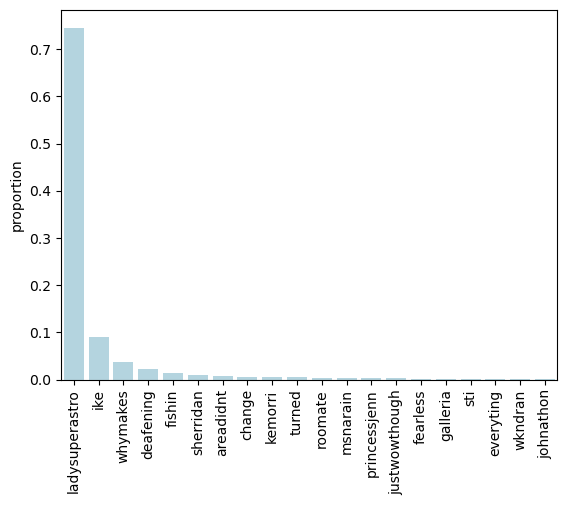

In [135]:
counts = pd.Series(word_count_list).value_counts(normalize = True)[:20]
words = [vocab[x] for x in counts.index][:20]
g = sns.barplot(x = words, y = counts, color = 'lightblue')
g.set_xticks(range(len(words)))  # Set the x-axis ticks
g.set_xticklabels(labels=words, rotation=90)  # Set the tick labels
plt.show();

We can see the bar plot is very skewed. There are too many words that appear few times. Let's check out a 20-word sample from the trimmed list.

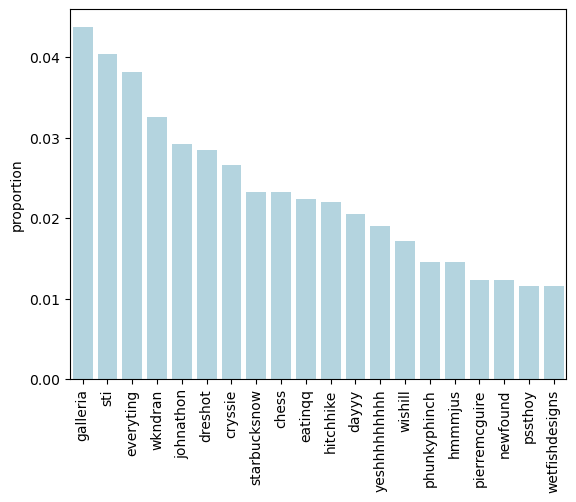

In [136]:
trimmed_word_counts = doc_term_mat_trimmed.sum(axis = 0)
trimmed_word_list = trimmed_word_counts.tolist()[0]

counts = pd.Series(trimmed_word_list).value_counts(normalize = True)[:20]
# counts = counts.reset_index(drop = True)
words = [vocab[x] for x in counts.index][:20]
g = sns.barplot(x = words, y = counts, color = 'lightblue')
g.set_xticks(range(len(words)))  # Set the x-axis ticks
g.set_xticklabels(labels=words, rotation=90)  # Set the tick labels
plt.show();

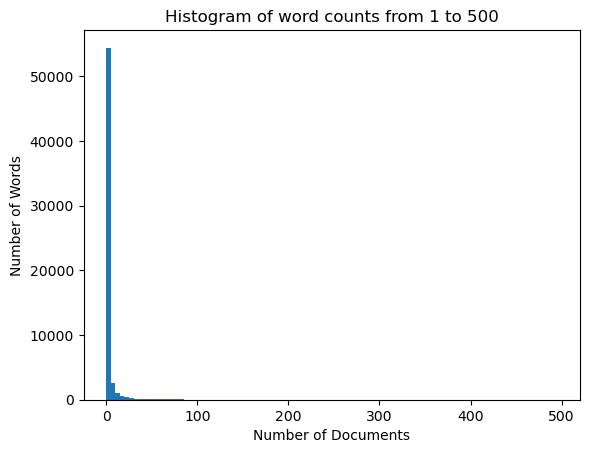

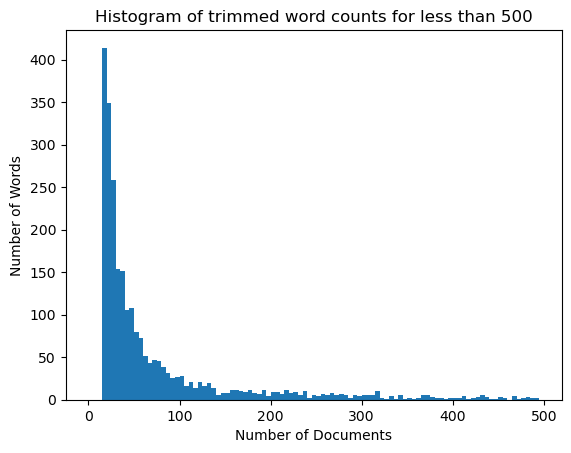

In [137]:
# Count of words for each appearance
hist_breaks = np.arange(0, 500, 5)
plt.hist(word_count_list, bins = hist_breaks)
plt.xlabel('Number of Documents')
plt.ylabel('Number of Words')
plt.title('Histogram of word counts from 1 to 500')
plt.show()

# Too many words appear few times. Check out trimmed.
trimmed_word_counts = doc_term_mat_trimmed.sum(axis=0)
trimmed_word_list = trimmed_word_counts.tolist()[0]
hist_breaks = np.arange(0, 500, 5)
plt.hist(trimmed_word_list, bins = hist_breaks)
plt.xlabel('Number of Documents')
plt.ylabel('Number of Words')
plt.title('Histogram of trimmed word counts for less than 500')
plt.show()

Note that 15 might be a good cutoff, but these types of **hyperparameters** for the model will probably need tuning. We will learn about tuning such values in future lectures.

### Step 3: Compute IDF

Recall that we compute IDF values using the following formula:

$$\text{IDF(term)} = \log(\frac{\text{number of documents}}{\text{number of documents with term in it}})$$

The advantage of using a linear algebra library like numpy is that we can easily implement this in a few lines of code without having to write loops.

In [138]:
tf_mat_trimmed = doc_term_mat_trimmed / (doc_term_mat_trimmed.sum(axis = 1) + 0.0000000000001)
# vocab_trimmed

In [139]:
idf_mat_trimmed = doc_term_mat_trimmed.sum(axis = 0) # This should be axis = 0
idf_mat_trimmed = np.log((doc_term_mat_trimmed.shape[0] + 1) / (idf_mat_trimmed + 1))
idf_mat_trimmed = idf_mat_trimmed.reshape(-1).transpose()
idf_mat_trimmed.shape

(2674, 1)

### Step 4: Compute TF-IDF

Finally, we can now compute the TF-IDF vaules by just multiplying the TF and IDF arrays. Let's first check their dimensions:

In [140]:
print("TF has shape {} and IDF has shape {}".format(tf_mat_trimmed.shape, idf_mat_trimmed.shape))

TF has shape (50000, 2674) and IDF has shape (2674, 1)


By "multiplying" the two arrays, we are NOT talking about matrix multiplication. What we do is multiply each column of the TF matrix (the terms) with its corresponding value of the IDF vector for that term. This multiplication can be very slow so we have the code commented out. In the next exercise, we re-implement TF-IDF but use the efficient `sklern` implementation.

In [141]:
# tf_idf_mat = np.multiply(tf_mat_trimmed, csr_matrix(idf_mat_trimmed))
# tf_idf_mat

### Exercise (5 minutes)

Unfortunately, our `numpy` implementation of TF-IDF would be very slow even on this smallish dataset. So we commented out the code above. But there is a much more efficient implementation of TF-IDF in `sklearn` and it does all of the computation steps behind the scenes. All we need to do is pass it the tokenized data. So in practice, we can use the `TfidfVectorizer` function to do all the calculations for us. 

- Take a moment to familiarize yourself with this function and use it to get TF-IDF features from the tweets that we cleaned earlier. Notice the similarities between this function and similar functions in `sklearn` we learned eariler.

In [142]:
clean_texts = tweet_df['clean_tweet']

vectorizer = TfidfVectorizer(max_features = 500)
tfidf_matrix =  vectorizer.fit_transform(clean_texts)
doc = 0
feature_names = vectorizer.get_feature_names_out()
tfidf_matrix_dense = tfidf_matrix.toarray()
tfidf_df = pd.DataFrame(tfidf_matrix_dense, columns = feature_names)

In [143]:
print(tfidf_df.shape)
tfidf_df.head()

(50000, 500)


,able,about,actually,after,again,ago,ah,all,almost,already,...,yay,yeah,year,yes,yesterday,yet,you,youll,your,youre
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.381326,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.194183,0.0,0.279238,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.293734,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0


In [144]:
tfidf_df.describe()

,able,about,actually,after,again,ago,ah,all,almost,already,...,yay,yeah,year,yes,yesterday,yet,you,youll,your,youre
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.001405,0.009578,0.002571,0.004230,0.007091,0.001470,0.001765,0.013825,0.001935,0.003533,...,0.003850,0.005410,0.003516,0.004729,0.002544,0.003196,0.037711,0.001285,0.012676,0.005234
std,0.023919,0.057385,0.033053,0.039728,0.054599,0.025084,0.030453,0.064396,0.029413,0.041177,...,0.044451,0.049279,0.036894,0.048468,0.032996,0.036983,0.102167,0.024627,0.067439,0.049173
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.732708,1.000000,1.000000,0.836829,1.000000,0.738381,1.000000,1.000000,0.840678,1.000000,...,1.000000,1.000000,0.807786,1.000000,1.000000,0.910379,1.000000,0.805481,1.000000,1.000000


The 'csr' (compressed sparse row) format is used by `sklearn` to store the matrix.

### End of exercise

## (Optional) Classification and sentiment analysis

It's hard to talk about feature engineering without moving on to the next step: training a machine learning model. Although we cover this topic on a future lesson, we include here an example in case you can't wait any longer!

Now that we have a prepared DTM of the 50000 tweets, let's build and evaluate models to classify the sentiment of these tweets. The idea is simple: We use the TF-IDF features for training the model. Since our data also has a column that says if the tweet expresses a positive or negative sentiment, we will train a model to predict the sentiment from the TF-IDF features. So first let's obtain the TF-IDF features once more:

In [145]:
vectorizer = TfidfVectorizer(sublinear_tf = True, max_df = 0.5, max_features = 6228, stop_words = 'english')
clean_texts = tweet_df['clean_tweet']
tf_idf_tweets = vectorizer.fit_transform(clean_texts)

tf_idf_tweets

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 276192 stored elements and shape (50000, 6228)>

Let's split the featurized data into training and test sets. We will explain why in a future lecture. For training we will use 70% to 90% tweets to predict the 0,1 sentiment. The remaining cases will be used to evaluate the model.

In [146]:
y_targets = np.array([y[0] for y in tweet_data])
X_train, X_test, y_train, y_test = train_test_split(tf_idf_tweets, y_targets, test_size = 5000, random_state = 42)

In [147]:
print(type(X_train), X_train.shape)

<class 'scipy.sparse._csr.csr_matrix'> (45000, 6228)


Now let's train a logistic classifier on the data:

In [148]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

Let's now evaluate the model.

In [149]:
train_results = lr.predict(X_train)
test_results = lr.predict(X_test)

In [150]:
train_acc = np.mean(y_train == train_results)
test_acc = np.mean(y_test == test_results)

print('Train accuracy: {}'.format(train_acc))
print('Test accuracy: {}'.format(test_acc))
print('Baseline accuracy: {}'.format(np.max([np.mean(y_test == 1), np.mean(y_test == 0)])))

Train accuracy: 0.7926
Test accuracy: 0.7514
Baseline accuracy: 0.5068


Let's also compute the precision, recall and Fscore of the model for positive and negative tweets.

Recall that a positive prediction here means a positive review, and so **precision** is the proportion of correct predictions among all positive predictions and **recall** is the proportion of correct predictions among all true positives. **F1** is the harmonic average of precision and recall.

In [151]:
precision, recall, f1, support = precision_recall_fscore_support(y_test, test_results)
tn, fp, fn, tp = confusion_matrix(y_test, test_results).ravel()

print(confusion_matrix(y_test, test_results))
print('='*35)
print('             Class 1   -   Class 0')
print('Precision: {}'.format(precision))
print('Recall   : {}'.format(recall))
print('F1       : {}'.format(f1))
print('Support  : {}'.format(support))

[[1877  657]
 [ 586 1880]]
             Class 1   -   Class 0
Precision: [0.76207877 0.74103272]
Recall   : [0.74072612 0.76236821]
F1       : [0.75125075 0.75154907]
Support  : [2534 2466]


##  Summary

NLP applications extend far and wide, so we only stratched the surface here. Many of the modern breakthroughs in deep learning for example have been in NLP. One reason for this is that language data is abundant and the lack of structure in the data presents us with many challenges and learning opportunities. We hope this notebook exposed you to just some examples.

# Assignment

1. use pandas read_csv with sep='\t' to read in the following 2 files available from the us naval academy:
- url = 'https://www.usna.edu/Users/cs/nchamber/data/twitter/keyword-tweets.txt'
- url = 'https://www.usna.edu/Users/cs/nchamber/data/twitter/general-tweets.txt'
<br/> <span style="color:red" float:right>[1 point]</span>

2. concatenate these 2 data sets into a single data frame called LabeledTweets that has 2 columns, named Sentiment and Tweet <span style="color:red" float:right>[1 point]</span>

3. replace sentiment labels 'POLIT': 1, 'NOT': 0; <span style="color:red" float:right>[0 point]</span>

4. clean the tweets
   1. remove all tokens that contain a "@". Remove the whole token, not just the character.
   2. remove all tokens that contain "http". Remove the whole token, not just the characters.
   3. **replace** (not remove) all punctuation marks with a space (" ")
   4. **replace** all numbers with a space
   5. **replace** all non ascii characters with a space
   7. convert all characters to lowercase
   8. strip extra whitespaces
   9. lemmatize tokens
   9. No need to remove stopwords because TfidfVectorizer will take care of that
<br/><span style="color:red" float:right>[9 point]</span>

5. Use TfidfVectorizer from sklearn to prepare the data for machine learning.  Use max_features = 50;  <span style="color:red" float:right>[2 point]</span>

6. Use sklearn LogisticRegression to train a model on the  results on 75% of the data. <span style="color:red" float:right>[1 point]</span>

7. determine the accuracy on the training data and the test data.   Determine the baseline accuracy. <span style="color:red" float:right>[1 point]</span>

8. Repeat steps 5, 6, and 7  with TfidfVectorizer max_features set to 5, 500, 5000, 50000 and discuss your accuracies. <span style="color:red" float:right>[2 point]</span>

# End of assignment